## CNN text classification on Amazon food reviews

Literature on CNNs for NLP tasks:

1) http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

2) https://arxiv.org/pdf/1404.2188.pdf

3) https://arxiv.org/pdf/1408.5882.pdf

4) http://cs224d.stanford.edu/reports/RhodesDylan.pdf

5) http://cs224d.stanford.edu/reports/DufourNick.pdf


Word2vec explained:
- http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
- http://stats.stackexchange.com/questions/244616/how-sampling-works-in-word2vec-can-someone-please-make-me-understand-nce-and-ne/245452#245452

How to use tensorboard:
- http://ischlag.github.io/2016/06/04/how-to-use-tensorboard/

Inspired by:
- http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
- https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [1]:
import pandas as pd
from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import FreqDist
import operator
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [26]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

## Load dataset & process it

In [3]:
df = pd.read_csv("../data/Reviews.csv")
df.columns = map(lambda x: x.lower(), df.columns)
## remove neutral reviews
df=df[df.score!=3].copy()

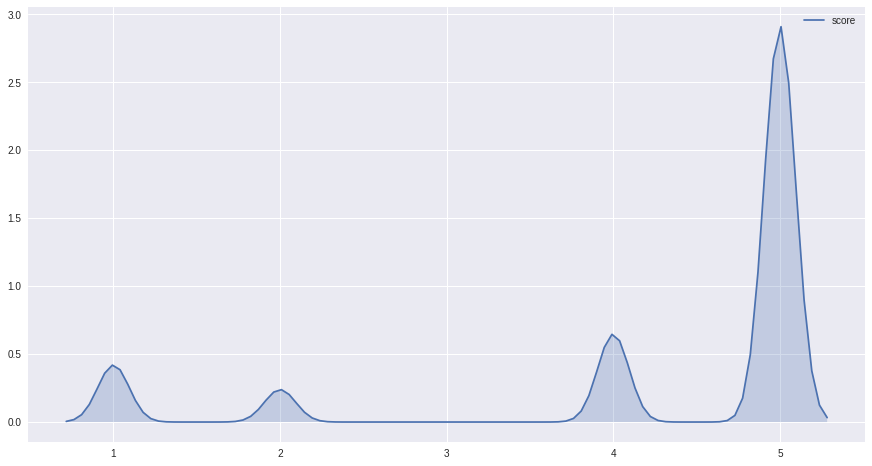

In [4]:
## score distribution
plt.figure(figsize=(15,8))
sns.kdeplot(df.score, shade=True)

In [5]:
df["text"] = df["text"].apply(lambda x: cleanData(x,[]))
df["negative"] = df["score"].apply(lambda x: 1 if x<3 else 0)
df["text_length"] = df["text"].apply(lambda x: getSentenceLength(x))

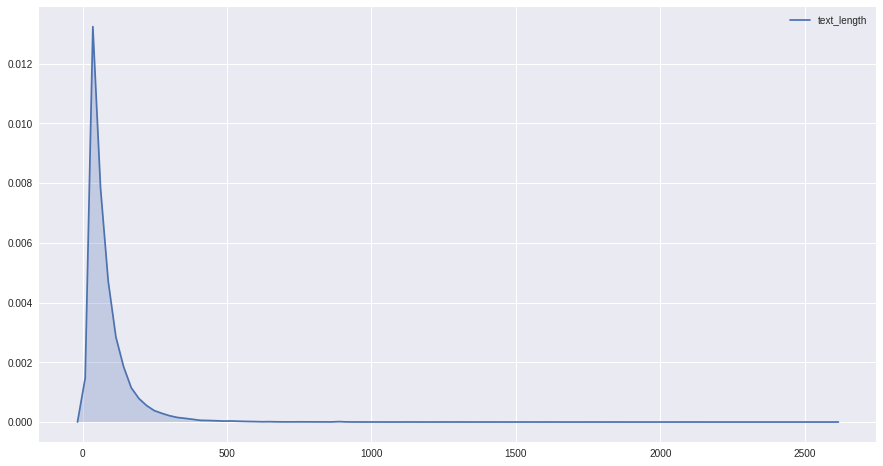

In [6]:
## review length distribution
plt.figure(figsize=(15,8))
sns.kdeplot(df.text_length, shade=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525814 entries, 0 to 568453
Data columns (total 12 columns):
id                        525814 non-null int64
productid                 525814 non-null object
userid                    525814 non-null object
profilename               525798 non-null object
helpfulnessnumerator      525814 non-null int64
helpfulnessdenominator    525814 non-null int64
score                     525814 non-null int64
time                      525814 non-null int64
summary                   525789 non-null object
text                      525814 non-null object
negative                  525814 non-null int64
text_length               525814 non-null int64
dtypes: int64(7), object(5)
memory usage: 52.2+ MB


In [8]:
## remove reviews with length more than 200
df = df[df.text_length<=200].copy()
## if length of a review is shorter than 200; fill it in with placeholer words
df["text_adj"] = df["text"].apply(lambda x: add_placeholders(x))

In [9]:
df.head(2)

,id,productid,userid,profilename,helpfulnessnumerator,helpfulnessdenominator,score,time,summary,text,negative,text_length,text_adj
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,0,48,i have bought several of the vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,1,32,product arrived labeled as jumbo salted peanut...


In [9]:
#df = df.sample(n=200000, random_state=0).copy()

In [10]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

## replace rare words (occur only once)
words_to_replace = [k for k, v in dict(word_dist).items() if v == 1]

word_lookup = dict()
for word in dict(word_dist).keys():
    if word in words_to_replace:
        word_lookup[word] = "rareword"
    else:
        word_lookup[word] = word

def replace_words(strg, words_to_replace):
    line = strg.split()
    line = [word_lookup[x] for x in line]
    result = ' '.join(line)
    return result

df["text_adj"] = df["text_adj"].apply(lambda x: replace_words(x, words_to_replace))

In [11]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

## take a look at dictionary
sorted_x = sorted(dict(word_dist).items(), key=operator.itemgetter(1))
print(sorted_x)

[('euclayptus', 2), ('frenchs', 2), ('transmit', 2), ('dyeria', 2), ('acd', 2), ('thorny', 2), ('pricking', 2), ('carons', 2), ('overstep', 2), ('parked', 2), ('signaling', 2), ('aristocats', 2), ('tanin', 2), ('synonomous', 2), ('llm', 2), ('rbgeow', 2), ('maryjanes', 2), ('unrelatedely', 2), ('faschi', 2), ('setiva', 2), ('flexability', 2), ('flirted', 2), ('dgfac', 2), ('allbran', 2), ('hitches', 2), ('moisterized', 2), ('trgw', 2), ('trottoloni', 2), ('altar', 2), ('shanti', 2), ('winthrop', 2), ('nlxl', 2), ('naturvet', 2), ('exspecially', 2), ('pastoral', 2), ('kalhua', 2), ('crunchberries', 2), ('leccino', 2), ('catstypically', 2), ('monotone', 2), ('unpleased', 2), ('ascribed', 2), ('splanda', 2), ('minerls', 2), ('caco', 2), ('drugging', 2), ('sitti', 2), ('chompchompchomp', 2), ('ptomaine', 2), ('ceilings', 2), ('xochitl', 2), ('carys', 2), ('courseness', 2), ('conniseuer', 2), ('cubing', 2), ('huichol', 2), ('quashing', 2), ('podravka', 2), ('mistate', 2), ('projector', 2), 

In [12]:
vocab = dict()
for e,y in enumerate(dict(word_dist).keys()):
    vocab[y]=e

In [13]:
len(vocab)

54238

In [14]:
vocab

{'tube': 0,
 'lj': 1,
 'zap': 2,
 'euclayptus': 3,
 'frenchs': 4,
 'tget': 8799,
 'ut': 6,
 'feeders': 7,
 'laugh': 8,
 'extemely': 17673,
 'saunier': 35639,
 'authority': 72,
 'care': 12,
 'deserving': 35640,
 'inherent': 14,
 'eligibility': 15,
 'tyvm': 16,
 'alderwood': 17,
 'defined': 18,
 'spindly': 19,
 'sluggishness': 20,
 'irina': 21,
 'injoy': 23,
 'saved': 24,
 'severely': 25,
 'directive': 26,
 'youi': 27,
 'disintegrating': 28,
 'acd': 29,
 'noodles': 30,
 'allready': 31,
 'oranges': 32,
 'dzdj': 33,
 'rattled': 34,
 'puupy': 8803,
 'voluntary': 36,
 'pa': 37,
 'aroundl': 38,
 'opion': 39,
 'arabic': 40,
 'soooo': 41,
 'scissors': 42,
 'thorny': 43,
 'formulating': 44,
 'tackiest': 26650,
 'pricking': 46,
 'caco': 228,
 'hesitates': 48,
 'sncaks': 49,
 'carons': 50,
 'currys': 51,
 'overstep': 52,
 'sot': 53,
 'athiest': 54,
 'virtues': 55,
 'cater': 56,
 'echoes': 53861,
 'nanosecond': 57,
 'parked': 59,
 'radicals': 60,
 'refreshes': 61,
 'signaling': 63,
 'paletable': 17

In [15]:
## map each sentence to a vector of words:
sentence_vecs = np.array(df["text_adj"].apply(lambda x: create_sentence_vectors(x, vocab)).tolist())

In [16]:
sentence_vecs

array([[32635,  9091, 10441, ..., 16217, 16217, 16217],
       [14043, 47564, 44869, ..., 16217, 16217, 16217],
       [ 6363, 21159, 30569, ..., 16217, 16217, 16217],
       ..., 
       [27385,  7653, 19708, ..., 16217, 16217, 16217],
       [27385, 19708, 37776, ..., 16217, 16217, 16217],
       [32635, 15934, 27755, ..., 16217, 16217, 16217]])

In [17]:
label_vecs = np.array(df.negative.tolist())

In [18]:
## train-valid-test split
train_dataset, test_dataset, train_labels, test_labels = \
                            train_test_split(sentence_vecs, label_vecs, test_size=0.3, random_state=0)
test_dataset, valid_dataset, test_labels, valid_labels = \
                            train_test_split(test_dataset, test_labels, test_size=0.33, random_state=0)

In [19]:
print ("Size of train set: %s" % len(train_dataset))
print ("Size of test set: %s" % len(test_dataset))
print ("Size of validation set: %s" % len(valid_dataset))

Size of train set: 344813
Size of test set: 99010
Size of validation set: 48767


In [20]:
train_dataset, train_labels

(array([[32640, 31343, 12304, ..., 16217, 16217, 16217],
        [30686, 37776,  5908, ..., 16217, 16217, 16217],
        [16211, 32635, 48640, ..., 16217, 16217, 16217],
        ..., 
        [32635, 45394,  6363, ..., 16217, 16217, 16217],
        [ 6363, 21159, 30569, ..., 16217, 16217, 16217],
        [27385, 19708, 15740, ..., 16217, 16217, 16217]]),
 array([0, 1, 0, ..., 0, 0, 0]))

## Ready for tensorflow!

In [22]:
SEQ_LENGTH = 200
BATCH_SIZE = 50
NUM_LABELS = 2

VOCAB_SIZE = len(vocab)
EMBED_SIZE = 128

FILTER_SIZE_1 = 3
FILTER_SIZE_2 = 4
FILTER_SIZE_3 = 5
NUM_FILTERS = 128

keep_prob = 0.8

tf_train_dataset = tf.placeholder(tf.int32, shape=(BATCH_SIZE, SEQ_LENGTH))
tf_train_labels = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
tf_valid_dataset = tf.constant(valid_dataset) 
tf_test_dataset = tf.constant(test_dataset)

# Keeping track of l2 regularization loss (optional)
#l2_loss = tf.constant(0.0)

## Embedding layer

embed_weigths = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMBED_SIZE], -1.0, 1.0))
    
## Convolutional layers
## Change to True if run again
with tf.variable_scope("vars", reuse = None):
    
    conv1_weights = tf.get_variable("conv1_w", shape=[FILTER_SIZE_1, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv1_b")

    conv2_weights = tf.get_variable("conv2_w", shape=[FILTER_SIZE_2, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv2_b")

    conv3_weights = tf.get_variable("conv3_w", shape=[FILTER_SIZE_3, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv3_b")

## Fully connected layer

    fc1_weights = tf.get_variable("fc1_w", shape=[3*NUM_FILTERS, NUM_LABELS],\
                                                initializer=tf.contrib.layers.xavier_initializer())
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]), name = "fc1_b")

# Model:
def model(data, keep_prob = keep_prob): 
    
    ## Embedding layer
    ## input shape:[BATCH_SIZE, SEQ_LENGTH]
    ## output shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    
    with tf.device('/cpu:0'), tf.name_scope("embedding"):    
        embed_chars = tf.nn.embedding_lookup(embed_weigths, data)
        embed_chars = tf.expand_dims(embed_chars, -1)
    
    ## Conv1+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    conv1 = tf.nn.conv2d(embed_chars, conv1_weights, strides=[1, 1, 1, 1], padding="VALID")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
    pool1 = tf.nn.max_pool(relu1, ksize=[1, SEQ_LENGTH-FILTER_SIZE_1+1, 1, 1],
                           strides=[1, 1, 1, 1], padding='VALID')
    ## Conv2+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    conv2 = tf.nn.conv2d(embed_chars, conv2_weights, strides=[1, 1, 1, 1], padding="VALID")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
    pool2 = tf.nn.max_pool(relu2, ksize=[1, SEQ_LENGTH-FILTER_SIZE_2+1, 1, 1],
                           strides=[1, 1, 1, 1], padding='VALID')
    
    ## Conv3+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    conv3 = tf.nn.conv2d(embed_chars, conv3_weights, strides=[1, 1, 1, 1], padding="VALID")
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
    pool3 = tf.nn.max_pool(relu3, ksize=[1, SEQ_LENGTH-FILTER_SIZE_3+1, 1, 1],
                           strides=[1, 1, 1, 1], padding='VALID')
    
    ## Combine pooled features + flatten
    ## input shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    ## output shape: [BATCH_SIZE, 3, 1, 1, NUM_FILTERS]
    
    pooled_outputs = [pool1, pool2, pool3]
    h_pool = tf.concat(pooled_outputs,3)
    h_pool_flat = tf.reshape(h_pool, [-1, NUM_FILTERS*3])
    h_pool_flat = tf.nn.dropout(h_pool_flat, keep_prob)
    
    ## Fully connected layer
    return tf.matmul(h_pool_flat, fc1_weights) + fc1_biases  
  
# Training computation:
logits = model(tf_train_dataset)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
# Optimizer:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# with tf.name_scope("output"):
#            W = tf.get_variable(
#                "W",
#                shape=[num_filters_total, num_classes],
#                initializer=tf.contrib.layers.xavier_initializer())
#            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
#            l2_loss += tf.nn.l2_loss(W)
#            l2_loss += tf.nn.l2_loss(b)
#            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
#            self.predictions = tf.argmax(self.scores, 1, name="predictions")
#
#        # CalculateMean cross-entropy loss
#        with tf.name_scope("loss"):
#            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
#            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


In [23]:
## remove objects from memory
del word_dist
del word_lookup

**Predictions for the training, validation, and test data**

In [24]:
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

## Train model and report accuracy

In [30]:
NUM_ITERATIONS = 1001

step = []
pred = []
loss_minibatch = []
accuracy_minibatch = []
accuracy_valid = []

logs_path = '../tensorflow_logs/example'

with tf.Session() as session:
    tf.global_variables_initializer().run()
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for i in range(NUM_ITERATIONS):
        offset = (i * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
        
        if (i % 200 == 0): ## info will be printed every 1000th time
            #predictions = np.argmax(predictions, 1)
            step.append(i)
            print("Minibatch loss at step %d: %f" % (i, l))
            loss_minibatch.append(l)
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            accuracy_minibatch.append(accuracy(predictions, batch_labels))
            #print("Minibatch f1 score: %.1f%%" % f1_score(predictions, batch_labels))
            #accuracy_minibatch.append(f1_score(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
            accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
            #accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
            
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    #save_path = saver.save(session, "../models/SVHN_MODEL.ckpt")
    #print("Model saved in file: %s" % save_path)
    
    #pred.append(test_prediction.eval(), 1)
    
    print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://172.26.179.29:6006/ into your web browser")

#pred = pred[0]

#def accuracy(predictions, labels):
#    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

Minibatch loss at step 0: 0.718236
Minibatch accuracy: 46.0%
Validation accuracy: 63.9%
Validation accuracy: 64.1%
Minibatch loss at step 200: 0.391989
Minibatch accuracy: 84.0%
Validation accuracy: 84.6%
Validation accuracy: 84.6%
Minibatch loss at step 400: 0.283092
Minibatch accuracy: 90.0%
Validation accuracy: 85.1%
Validation accuracy: 85.0%
Minibatch loss at step 600: 0.260687
Minibatch accuracy: 90.0%
Validation accuracy: 85.1%
Validation accuracy: 85.1%
Minibatch loss at step 800: 0.201020
Minibatch accuracy: 94.0%
Validation accuracy: 85.9%
Validation accuracy: 86.0%
Minibatch loss at step 1000: 0.390799
Minibatch accuracy: 84.0%
Validation accuracy: 86.9%
Validation accuracy: 86.7%

Test accuracy: 86.8%


TypeError: append() takes exactly one argument (2 given)

In [78]:
pred

[]

In [32]:
print precision_score(test_labels, pred)
print recall_score(test_labels, pred)
print accuracy_score(test_labels, pred)
print f1_score(test_labels, pred)
confusion_matrix(test_labels, pred)

0.820322443784
0.628167641326
0.921990049751
0.711499540018


array([[33197,   847],
       [ 2289,  3867]])

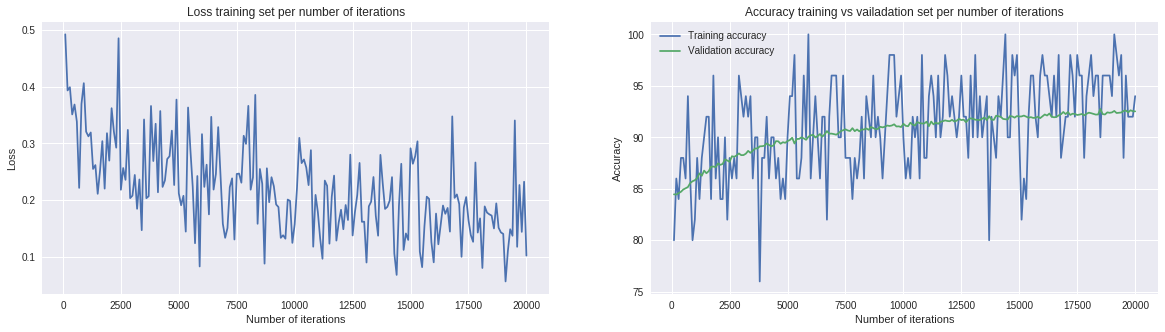

In [35]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(step[1:len(step)],loss_minibatch[1:len(step)])
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss training set per number of iterations')

plt.subplot(1, 2, 2)
plt.plot(step[1:len(step)],accuracy_minibatch[1:len(step)], label = 'Training accuracy')
plt.plot(step[1:len(step)],accuracy_valid[1:len(step)], label = 'Validation accuracy')
plt.legend(loc = 0)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy training vs vailadation set per number of iterations')